<a href="https://colab.research.google.com/github/fjtm/Data/blob/master/dogsVScats_francisco_javier_tebar_martinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab assignment: dogs VS cats

###Francisco Javier Tébar Martínez

15/04/2019

<table><tr>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/doge.jpg"   height="400" width="400"></td>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/cat.jpg" height="400" width="400"></td>
</tr></table>

In this assignment we will face an image classification problem, trying to tell apart images of dogs and images of cats. The final battle begins! And to do so we will use a Deep Learning approach.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Deep Learning environment files](https://github.com/albarji/teaching-environments/tree/master/deeplearning).

The following code will embed any plots into the notebook instead of generating a new window:

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

In [0]:
import glob
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
import time
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Input
from keras.models import Model
from keras.applications import vgg16

from sklearn.metrics import confusion_matrix

**Creamos una carpeta en el directorio actual con los datos de la práctica almacenados en github (Este proceso es un poco lento pero permite ejecutar el notebook tanto en local, como en google colab). Si bien, si no se trabaja con google colab y  se disponen de los datos, recomiendo crear una carpeta de nombre Data en el directorio actual con los datos de train y test para mayor velocidad, en vez de clonar el repositorio de github.** 

In [341]:
!git clone --recursive https://github.com/fjtm/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


## Data processing

The images to use in this assignment are available [here](https://drive.google.com/open?id=105jGDrjEgxx2W2gYhFF8Mbf1J9qJeDPm). Download the data package and extract it into a folder in your computer.

Data is structured under two folders, *train* and *test*. You are only allowed to use the *test* data to measure the performance of your model **after** you have finished training. Both *train* and *test* folders contain one subfolder per class (*cats* and *dogs*).

The recommended way to load an image from disk is to use the *imread* function from the *scikit-image* library. For example:

In [0]:
image = imread("Data/img/sample.jpg")

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [343]:
image.shape

(499, 367, 3)

We can visualize the loaded image using

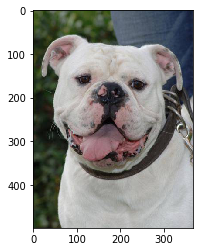

In [344]:
plt.imshow(image)

The dataset includes 20000 training images and 5000 test images, each image at a different resolution. Loading all this data at once requires too much memory, so we will need to **resize** each image to a smaller, common size as we load them from disk. We can do so by again making use of a *scikit-image* function. For example:

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


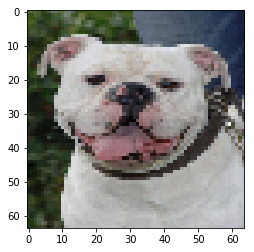

In [345]:
size = 64
smallimage = resize(image, (64, 64, 3), mode="reflect")  # 64 x 64 pixels, 3 color channels
plt.imshow(smallimage)


<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    
Perform the following tasks to prepare the data:
- Build a numpy array *X_train* containing one entry for each training image in the data. Each entry must contain the 3-dimensional matrix of pixels corresponding to an image. Make sure to scale down each image to a common size
- Normalize *X_train* so that pixels follow a distribution lying in the range [-0.5,0.5]
- Build a corresponding array *Y_train* with the class of each training image (0 for cats and 1 for dogs).
- Randomly shuffle the data. Make sure you shuffle both *X_train* and *Y_train* using the same permutation, so you don't lose track of the class of each training pattern.

- Repeat the whole procedure again to generate *X_test* and *Y_test* matrices for the test data.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
- Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
- Since you need to repeat the procedure both for training and test data, it would be useful to implement a function that performs all the data loading and transforming steps.
</font>

***

Creamos una función que tomando una imagen la reescala, creando un cubo de datos con el tamaño de la imagen (filas y columnas) y el número de canales. (tamaño de las filas, tamaño de las columnas, canales (RGB)). Además desplazamos la distribución de pixeles originales entre $[0,1]$ a $[-0.5,0.5]$.

In [0]:
def preprocesing(image, size = 64, mode = "reflect"):
    return(np.array(resize(imread(image), (size, size, 3), mode=mode, anti_aliasing=True)-0.5))

In [347]:
X_train = []
Y_train = []
X_test = []
Y_test = []

print("Loading cats train")
for image in glob.glob('Data/train/cats/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(0)
print("Loading dogs train")
for image in glob.glob('Data/train/dogs/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(1)
print("Loading cats test")
for image in glob.glob('Data/test/cats/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(0)
print("Loading dogs test")
for image in glob.glob('Data/test/dogs/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(1)
print("Complete")

Loading cats train
Loading dogs train
Loading cats test
Loading dogs test
Complete


If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [348]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

X_train size 20000
Y_train size 20000
X_test size 5000
Y_test size 5000


Cambiamos el formato de X_train y X_test a un ndarray con (número de imagenes, 64, 64, 3) y mezclamos las imágenes. En este trabajo no se trabajará con imagenes con mayor resulición ya que sino podemos tener problemas de memoria.

In [0]:
np.random.seed(12)
index_train = np.arange(20000)
np.random.shuffle(index_train)
index_test = np.arange(5000)
np.random.shuffle(index_test)

In [0]:
X_train = np.asarray(X_train)[index_train]
X_test = np.asarray(X_test)[index_test]
Y_train = np.asarray(Y_train)[index_train]
Y_test = np.asarray(Y_test)[index_test]

Modificamos las etiquetas creando las categorías.  

In [0]:
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)

## Basic deep model

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***
<font color=#ad3e26>
Create a deep network that achieves at least a 60% of accuracy in the test set. Make use of the layers you seem fit for problem. You cannot use the test data for fitting the network, but you can use it to check the final performance of different network architectures, and select the architecture performing best.</font>

***

En esta primera parte mostraré algunas de las CNN que he probado y que van aumentando en complejidad hasta la arquitectura elegida:

<ol>
1. CNN 1:
    <br>
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa Densa con 2 neuronas (Con función de activación sigmoide)
    </ul>  
2. CNN 2:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 64 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
3. CNN 3:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 256 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
4. CNN 4: 
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
5. CNN 5:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
  </ol>

Antes de utilizar estos modelos es necario tomar algunas consideraciones.
<ol>
<li> <b>Función de pérdida</b> </li>
    <ul>
De entre la gran variedad de funciones de pérdida disponibles en keras, he elegido <b>binary crossentropy</b> puesto que tenemos un problema de clasificiación con solamente dos clases. Esta se puede expresar como:

$$H_p(q) = -\frac{1}{N_0 + N_1}[\sum_{i=1}^{N_0}log(p(y_i)) + \sum_{i=1}^{N_1}log(p(y_i))]$$
con $N_0$ el número de gatos y $N_1$ el número de perros. 
</ul>
<li> <b>Solver de optimización</b> </li>
<ul> 
En este caso utilizaremos el solver de optimización <b>adam</b> ya que funciona bien para problemas con muchos datos y/o parámetros.
</ul>
<li> <b>Número de epochs</b> </li>
<ul>    
Designa el número de veces que la red neuronal utilizará todos los datos de entrenamiento para actualizar los pesos. En este caso, de manera un poco manual considero que unas <b>10</b> o <b>20</b> epochs son suficientes. 
</ul>
<li> <b>Tamaño del batch</b> </li>
<ul>   
Designa el tamaño del subconjunto de datos tomados de train para actualizar los gradientes. En este caso utilizaremos <b>128</b>.
</ul>
<li> <b>Métrica</b> </li>
<ul>
Puesto que tenemos un problema con las clases perfectamente balanceadas podemos utilizar una métrica simple como es <b>accuracy</b>. 
</ol>

## CNN 1

Creamos la arquitectura del modelo y lo compilamos con el solver anterior y la función de perdida anterior. 

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos la red con el tamaño del batch y el número de epochs

In [353]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 8s - loss: 0.6151 - acc: 0.6618
Epoch 2/20
 - 3s - loss: 0.5561 - acc: 0.7202
Epoch 3/20
 - 3s - loss: 0.5118 - acc: 0.7563
Epoch 4/20
 - 3s - loss: 0.4893 - acc: 0.7704
Epoch 5/20
 - 3s - loss: 0.4674 - acc: 0.7832
Epoch 6/20
 - 3s - loss: 0.4548 - acc: 0.7937
Epoch 7/20
 - 3s - loss: 0.4378 - acc: 0.7986
Epoch 8/20
 - 3s - loss: 0.4240 - acc: 0.8095
Epoch 9/20
 - 3s - loss: 0.4140 - acc: 0.8142
Epoch 10/20
 - 3s - loss: 0.4080 - acc: 0.8182
Epoch 11/20
 - 3s - loss: 0.3966 - acc: 0.8237
Epoch 12/20
 - 3s - loss: 0.3878 - acc: 0.8302
Epoch 13/20
 - 3s - loss: 0.3785 - acc: 0.8364
Epoch 14/20
 - 3s - loss: 0.3701 - acc: 0.8397
Epoch 15/20
 - 3s - loss: 0.3634 - acc: 0.8421
Epoch 16/20
 - 3s - loss: 0.3562 - acc: 0.8502
Epoch 17/20
 - 3s - loss: 0.3496 - acc: 0.8519
Epoch 18/20
 - 3s - loss: 0.3425 - acc: 0.8555
Epoch 19/20
 - 3s - loss: 0.3366 - acc: 0.8595
Epoch 20/20
 - 3s - loss: 0.3284 - acc: 0.8632


Vemos la actuación del modelo sobre los datos de test.

In [354]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 597us/step
Test loss 0.4996
Test accuracy 0.7724


Con este modelo bastante simple conseguimos un accuracy mayor del 70%. Aunque vemos como el modelo está realizando claramente overfit con un 10% más de accuracy sobre los datos de train. 

## CNN 2

Estudiemos los resultados con la segunda arquitectura considerada.

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [356]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 8s - loss: 0.6705 - acc: 0.5595
Epoch 2/20
 - 3s - loss: 0.6371 - acc: 0.5935
Epoch 3/20
 - 3s - loss: 0.6220 - acc: 0.6004
Epoch 4/20
 - 3s - loss: 0.6093 - acc: 0.6162
Epoch 5/20
 - 3s - loss: 0.5992 - acc: 0.6169
Epoch 6/20
 - 3s - loss: 0.5889 - acc: 0.6250
Epoch 7/20
 - 3s - loss: 0.5794 - acc: 0.6284
Epoch 8/20
 - 3s - loss: 0.5692 - acc: 0.6335
Epoch 9/20
 - 3s - loss: 0.5618 - acc: 0.6378
Epoch 10/20
 - 3s - loss: 0.5589 - acc: 0.6399
Epoch 11/20
 - 3s - loss: 0.5544 - acc: 0.6501
Epoch 12/20
 - 3s - loss: 0.5477 - acc: 0.6565
Epoch 13/20
 - 3s - loss: 0.5320 - acc: 0.6795
Epoch 14/20
 - 3s - loss: 0.5231 - acc: 0.7023
Epoch 15/20
 - 3s - loss: 0.5130 - acc: 0.7065
Epoch 16/20
 - 3s - loss: 0.5032 - acc: 0.7137
Epoch 17/20
 - 3s - loss: 0.4913 - acc: 0.7224
Epoch 18/20
 - 3s - loss: 0.4835 - acc: 0.7267
Epoch 19/20
 - 3s - loss: 0.4817 - acc: 0.7288
Epoch 20/20
 - 3s - loss: 0.4717 - acc: 0.7359


In [357]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 656us/step
Test loss 0.4897
Test accuracy 0.7603


Tenemos un resultado similar al del modelo anterior. Sin embargo, en este caso no tenemos overfit. 

## CNN 3

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='valid'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [359]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 10s - loss: 0.6063 - acc: 0.6626
Epoch 2/20
 - 4s - loss: 0.4981 - acc: 0.7581
Epoch 3/20
 - 4s - loss: 0.4501 - acc: 0.7894
Epoch 4/20
 - 4s - loss: 0.4080 - acc: 0.8132
Epoch 5/20
 - 4s - loss: 0.3730 - acc: 0.8345
Epoch 6/20
 - 4s - loss: 0.3321 - acc: 0.8557
Epoch 7/20
 - 4s - loss: 0.2909 - acc: 0.8772
Epoch 8/20
 - 4s - loss: 0.2493 - acc: 0.8974
Epoch 9/20
 - 4s - loss: 0.2145 - acc: 0.9140
Epoch 10/20
 - 4s - loss: 0.1659 - acc: 0.9370
Epoch 11/20
 - 4s - loss: 0.1348 - acc: 0.9501
Epoch 12/20
 - 4s - loss: 0.1078 - acc: 0.9610
Epoch 13/20
 - 4s - loss: 0.0845 - acc: 0.9699
Epoch 14/20
 - 4s - loss: 0.0735 - acc: 0.9756
Epoch 15/20
 - 4s - loss: 0.0595 - acc: 0.9803
Epoch 16/20
 - 4s - loss: 0.0474 - acc: 0.9857
Epoch 17/20
 - 4s - loss: 0.0443 - acc: 0.9858
Epoch 18/20
 - 4s - loss: 0.0393 - acc: 0.9878
Epoch 19/20
 - 4s - loss: 0.0421 - acc: 0.9864
Epoch 20/20
 - 4s - loss: 0.0317 - acc: 0.9899


In [360]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 617us/step
Test loss 0.7474
Test accuracy 0.8256


En este caso conseguimos superar el 80% de accuracy. Sin embargo, si vemos el accuracy durante el entrenamiento, el modelo está realizando un overfit enorme.

## CNN 4

Notese que en este caso utilizamos el enfoque *same* ya que al utilizar tantas capas de MaxPooling necesitamos preservar que el tamaño de la imagen tras pasar las capas de convolución sea razonable.  

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [362]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 10s - loss: 0.6270 - acc: 0.6343
Epoch 2/10
 - 5s - loss: 0.5000 - acc: 0.7557
Epoch 3/10
 - 5s - loss: 0.4135 - acc: 0.8085
Epoch 4/10
 - 5s - loss: 0.3436 - acc: 0.8514
Epoch 5/10
 - 5s - loss: 0.2872 - acc: 0.8786
Epoch 6/10
 - 5s - loss: 0.2432 - acc: 0.8974
Epoch 7/10
 - 5s - loss: 0.1853 - acc: 0.9242
Epoch 8/10
 - 5s - loss: 0.1389 - acc: 0.9472
Epoch 9/10
 - 5s - loss: 0.0986 - acc: 0.9623
Epoch 10/10
 - 5s - loss: 0.0735 - acc: 0.9718


In [363]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 644us/step
Test loss 0.4668
Test accuracy 0.8649


Mejoramos el resultado anterior pero claramente mantenemos el overfit. 

## CNN 5

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [365]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 14s - loss: 0.6736 - acc: 0.5707
Epoch 2/10
 - 8s - loss: 0.5656 - acc: 0.7095
Epoch 3/10
 - 8s - loss: 0.4829 - acc: 0.7718
Epoch 4/10
 - 8s - loss: 0.4064 - acc: 0.8180
Epoch 5/10
 - 8s - loss: 0.3506 - acc: 0.8463
Epoch 6/10
 - 8s - loss: 0.2923 - acc: 0.8754
Epoch 7/10
 - 8s - loss: 0.2542 - acc: 0.8921
Epoch 8/10
 - 8s - loss: 0.2178 - acc: 0.9098
Epoch 9/10
 - 8s - loss: 0.1863 - acc: 0.9222
Epoch 10/10
 - 8s - loss: 0.1475 - acc: 0.9405


In [366]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 686us/step
Test loss 0.3556
Test accuracy 0.8661


Obtenemos el mejor resultado hasta al momento llegando casi al 90% de acierto. En este caso aunque la red sigue haciendo overfitting este no es tan pronunciado como las CNN anteriores. Así, quedemonos con esta arquitectura. 

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
If you are unable to attain the required 60% of accuracy, or your accuracy is too close to 100%, review the following checklist:
- Have you mixed training and test data?
- Have the values of the pixels been normalized?
- Have you compiled the model with a loss function appropriate for **binary** classification?
- Have you used ReLU units in the hidden layers? Have you used sigmoid or softmax layers in the output layer?

***

## Improving the network

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***

<font color=#259b4c>
    
You can further improve your results by applying one or more of the following strategies:
<li>
Keep apart a portion of the training data as a **validation set**. Then use an <a href="https://keras.io/callbacks/#earlystopping">**EarlyStopping strategy**</a> to monitor the loss of these validation data, and stop when training when after a number of iterations such loss has not decreased.
<li>
Make use of **metamodelling techniques** to select the best architecture parameters for the networks. You can use scikit-learn methods GridSearchCV or RandomSearchCV. You can do those by using the <a href="https://keras.io/scikit-learn-api/">KerasClassifier</a> wrapper. Even better, you can mix KerasClassifier with an advanced search method such as [BayesSearch](https://scikit-optimize.github.io/#skopt.BayesSearchCV), included in the [scikit-optimize](https://scikit-optimize.github.io/) library.
<li>
Use **image augmentation techniques** to artifically create new training images. To do so, you can make use of <a href="https://keras.io/preprocessing/image/">ImageDataGenerator</a> in Keras.
<li>
Make use of a pre-trained large network, building your network on top of it. You can find some examples in the [Keras Applications](https://keras.io/applications/) page.

If you correctly use these techniques you should be able to improve your model. With some effort it is possible to up to a 90% test accuracy. Try to do your best!</font>

***

IMPORTANTE

Ejecutar esta parte del código sin google colab requiere una gran cantidad de tiempo de entrenamiento. De esta manera, he guardado el modelo creado en el entorno de google colab en github. 

Una vez seleccionada la arquitectura de la red neuronal intentaremos mejorar el rendimiento de esta mediante las técnicas sugeridas. En concreto nos basaremos principalmente en dos de ellas:

<ol>
<li> <b>EarlyStopping strategy</b> </li>
    <ul>
Permite detener el entrenamiento si la función de pérdida en el conjunto de validación no decrece durante un cierto número de epochs, en concreto utilizaremos 5 epochs como margen. Puesto que 5 iteraciones pueden llevar a un mayor ovefit sin una mejora en el modelo, utilizaremos el parámetro <b>restore_best_weights</b> el cual devuelve los mejores pesos de las últimas 5 epochs en caso de que la función de perdida no decrezca durante estas iteraciones. Esta es una estrategia muy buena para controlar el overfit en las CNN.
</ul>

<li> <b>ImageDataGenerator</b> </li>
<ul> 
Esta técnica permite modificar las imagenes de train ligeramente mediante rotaciones, translaciones, zoom... Con esto se logra aumentar cosiderablemente el número de imágenes con las que entrenas el modelo sin necesidad de disponer de imágenes nuevas. 
</ul>
<br>

Para poder llevar a cabo las técnicas anteriormente comentadas es necesario separar un porcentaje de imágenes que utilizaremos para ir validando el modelo. Así, utilizaremos 2000 imágenes para validar y las 18000 restantes junto con la tecnica de aumentación de imágenes para entrenar la red. 

In [0]:
X_validate = X_train[0:2000]
Y_validate = Y_train[0:2000]
X_not_validate = X_train[2000:len(X_train)]
Y_not_validate = Y_train[2000:len(X_train)]

Creamos el generador de imágenes.

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

datagen.fit(X_not_validate)

Definimos la arquitectura.

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

En este caso aumentamos el número de epochs a 100, ya que EarlyStopping detendrá el algoritmo cuando la función de perdida del set de validación no decrezca.

In [0]:
# Ejecutar solamente en google colab o en un entorno con GPU

model_final = model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=0,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)] 
)

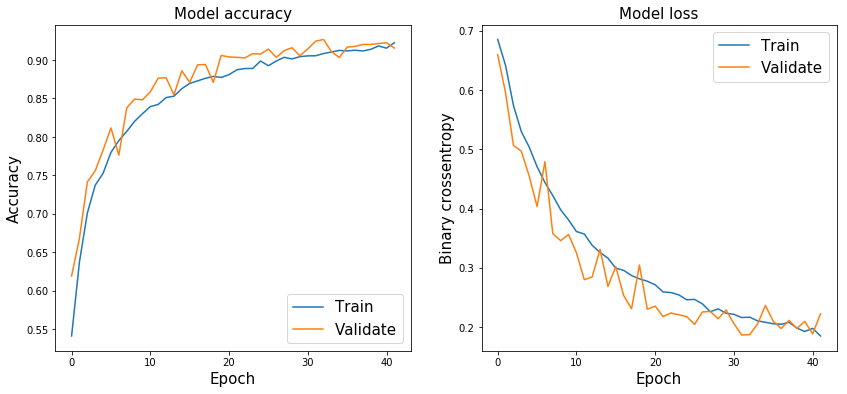

In [371]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(model_final.history['acc'])
plt.plot(model_final.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(model_final.history['loss'])
plt.plot(model_final.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('Binary crossentropy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)
plt.show()

In [372]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 258us/step
Test loss 0.1715
Test accuracy 0.9302


De esta manera utilizando estas técnicas, conseguimos mejorar el accuracy sobre el test entorno al $5$-$6\%$ con un modelo con la misma arquitectura. 

De las técnias sugeridas he intentado utilizar GridSearchCV para optimizar el número de neuronas por capa o el porcentaje de dropout de las capas densas..., sin embargo si se intenta trabajar con todas las imagenes nos quedamos sin memoria rapidamente. De esta manera utilizo una porción reducida de imagenes (12000) para intentar determinar el porcentaje de dropout óptimo. Realizo este proceso más para ilustrar como combinar GridSearchCV de sklearn con Keras, que para sacar un verdadero beneficio para construir el modelo.

In [0]:
def create_model(dropout_rate=0.0):
  
  img_rows = 64
  img_cols = 64
  kernel_size = 3 
  pool_size = 2

  model_drop = Sequential()

  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                          padding='same', input_shape=(img_rows, img_cols, 3)))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(256, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Flatten())
  model_drop.add(Dense(512))
  model_drop.add(Activation("relu"))
  model.add(Dropout(dropout_rate))
  model_drop.add(Dense(2))
  model_drop.add(Activation("sigmoid"))
  
  model_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_drop

In [374]:
model_drop = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
dropout_rate = [0.1,0.5,0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model_drop, param_grid=param_grid, cv = 3)
t0 = time.time()
grid_result = grid.fit(X_train[0:3000], Y_train[0:3000])
print("Tiempo de búsqueda:", np.round((time.time()-t0)/60,1), "min")

Tiempo de búsqueda: 4.7 min


In [375]:
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                              grid_result.cv_results_['std_test_score'],
                              grid_result.cv_results_['params']):
    print("Accuracy %f std (%f) con: %r" % (mean, stdev, param))

Best accuracy: 0.704000 using {'dropout_rate': 0.9}
Accuracy 0.693000 std (0.009192) con: {'dropout_rate': 0.1}
Accuracy 0.691833 std (0.040192) con: {'dropout_rate': 0.5}
Accuracy 0.704000 std (0.006745) con: {'dropout_rate': 0.9}


En este caso para  las tres posibilidades estudiadas, el modelo obtiene los mejores resultados para un dropout de 0.5 como veniamos utilizando hasta ahora.  

Llegados a este punto ya tenemos un buen modelo que consigue un accuracy de más del 90%. Probemos ahora a modificar un modelo ya existente para ver si logramos mejorar el resultado.

En este caso utilizaremos el modelo VGG16 presentado originalmente en el paper <a href = "https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> por K. Simonyan and A. Zisserman de la universidad de Oxford. Este presenta la siguiente arquitectura:



<td style="height:200px;">
    <table>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16.png"   height="200" width="800"></td>   
         </tr>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16-1-e1542731207177.png" height="400" width="800"></td>
         </tr>
    </table>
</td>

En concreto el modelo que podemos importar de keras solamente tiene las capas convolucionales,  y por tanto es necesario crear manualmente las capas densas. Además, este modelo toma imágenes de 226x226 y puesto que por impedimentos de memoria estamos trabajando con imágenes de 64x64, será necesario introducir otra capa inicial para redefinir el tamaño de entrada. 

Así nuestro modelo seguirá la estructura: 

<li> Capa de entrada (64,64,3)
<li> Estructura convolucional del modelo vvg16
<li> Flatten
<li> Capa densa de 512 neuronas con activación relu y dropout del 50%.
<li> Capa densa de 2 neuronas con activación sigmoide

In [383]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', classes = 2)

input = Input(shape=(64,64,3))
model_vgg16_mod = model_vgg16(input)

x = Flatten(name='flatten')(model_vgg16_mod)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
 
vgg16_tune_model = Model(input=input, output=x)

vgg16_tune_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [384]:
# Ejecutar solamente en google colab o en un entorno con GPU

vgg16_tune_model_results = vgg16_tune_model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=2,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)] 
)

Epoch 1/100
 - 36s - loss: 0.7259 - acc: 0.5639 - val_loss: 0.6092 - val_acc: 0.6982
Epoch 2/100
 - 24s - loss: 0.5729 - acc: 0.7102 - val_loss: 0.4953 - val_acc: 0.7630
Epoch 3/100
 - 24s - loss: 0.4666 - acc: 0.7825 - val_loss: 0.3634 - val_acc: 0.8497
Epoch 4/100
 - 24s - loss: 0.4294 - acc: 0.8053 - val_loss: 0.5518 - val_acc: 0.7485
Epoch 5/100
 - 24s - loss: 0.4179 - acc: 0.8100 - val_loss: 0.5519 - val_acc: 0.7600
Epoch 6/100
 - 25s - loss: 0.3592 - acc: 0.8439 - val_loss: 0.2671 - val_acc: 0.8908
Epoch 7/100
 - 24s - loss: 0.3288 - acc: 0.8577 - val_loss: 0.2720 - val_acc: 0.8973
Epoch 8/100
 - 24s - loss: 0.3139 - acc: 0.8663 - val_loss: 0.2384 - val_acc: 0.8975
Epoch 9/100
 - 25s - loss: 0.2886 - acc: 0.8755 - val_loss: 0.3709 - val_acc: 0.8370
Epoch 10/100
 - 24s - loss: 0.2819 - acc: 0.8803 - val_loss: 0.2072 - val_acc: 0.9100
Epoch 11/100
 - 24s - loss: 0.2504 - acc: 0.8961 - val_loss: 0.2067 - val_acc: 0.9135
Epoch 12/100
 - 25s - loss: 0.2529 - acc: 0.8923 - val_loss: 0.

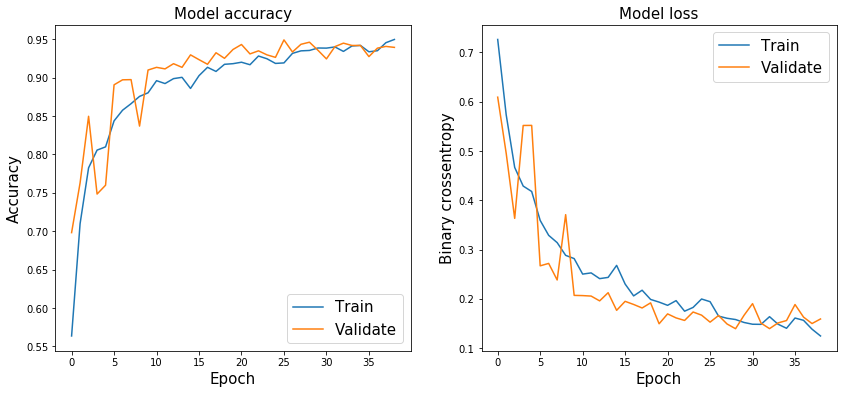

In [385]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(vgg16_tune_model_results.history['acc'])
plt.plot(vgg16_tune_model_results.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(vgg16_tune_model_results.history['loss'])
plt.plot(vgg16_tune_model_results.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('Binary crossentropy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)
plt.show()

In [386]:
score = vgg16_tune_model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 651us/step
Test loss 0.1207
Test accuracy 0.9489


## Analyzing the results

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Find and show some test images for which your model fails. Can you give an explanation for this behavior?</font>

***

Veamos algunas imágenes mal clasificadas por la CNN entrenada desde cero, es decir, nos centraremos en el último modelo construido sin contar el vgg16. Para ello representemos 12 de las imágenes mal clasificadas. Cabe destacar que cada vez que se ejecuta el código los parámetros de la red pueden cambiar y por tanto las imágenes erroneamente clasificadas también (además de alterarse el orden). Por tanto, me centraré en explicar las causas en general por las que considero que el modelo falla más que en detenerme en cada fotografía. 

In [0]:
pred = model.predict_classes(X_test)
real = Y_test.argmax(1)
fails = np.where(real != pred)[0]

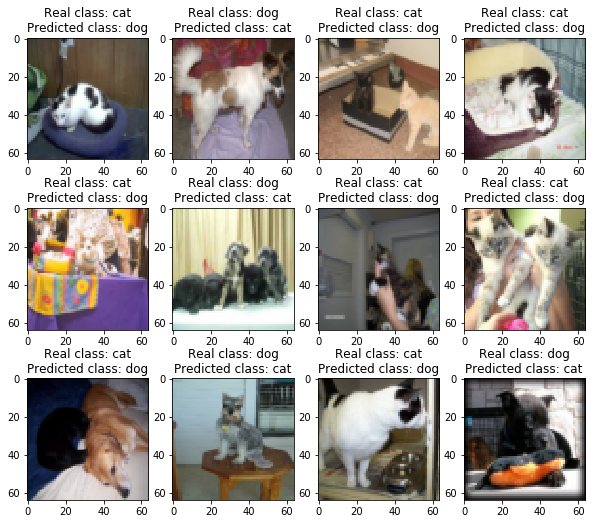

In [381]:
plt.figure(figsize=(10, 12))
for j, i in enumerate(range(0,12)):
  plt.subplot(4,4,j+1)
  plt.imshow(X_test[fails[i]]+0.5, 'gray')
  if real[fails[i]] == 0:
    real_label = "cat"
    predicted_label = "dog"
  else:
    real_label = "dog"
    predicted_label = "cat"
  plt.title("Real class: " + real_label + "\n" + "Predicted class: " + predicted_label)

No siempre es fácil entender porque el modelo falla en sus predicciones, aunque en ocasiones se puede suponer el porqué. Las siguientes posibles causas que he encontrado viendo las imagnes son:

<li> La imagen no es ni un gato ni un perro. Hay algunas imágenes que no contienen animales, hay alguna fotografías en las que sale solamente una persona.
<li> Cuando el animal ocupa una porción muy pequeña de la imagen. Con la baja resolución a veces es difícil saber visualmente si es un perro o un gato.
<li> Si en la imagen aparecen varios animales en vez de uno solo. 
<li> Clasifica en muchos casos erroneamente los perros que son completamente negros, o por el contrario los gatos que son completamente marrones. 
<li> Falla en varias ocasiones cuando el animal esta detrás de una valla o una reja. 
<li> Cuando aparecen personas sujetando al perro o el gato en muchas ocasiones clasifica erroneamente. 
<li> Creo que en algunos casos clasifica mal a los perros que tienen las orejas levantadas similares a como suelen ser las de los gatos.
<li> Finalmente creo que la posición en la que se encuentra el animal (tumbado...) influye en algunos casos en la clasificación erronea. 
  
Teniendo todo esto en cuenta resulta sorprendente como la CNN es capaz de clasificar correctamente un porcentaje tan grande de imágenes. 

Miremos finalmente si los errores están balanceados entre clases.

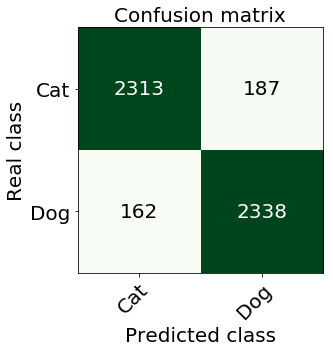

In [382]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
cm = confusion_matrix(real, pred)

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
               fontsize = 20)
        ax.set_ylabel('Real class', fontsize=20)
        ax.set_xlabel('Predicted class', fontsize=20)
        ax.set_title('Confusion matrix', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()

Como vemos el modelo se equivoca por igual en las dos clases.

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Write a small report summarizing the network choices you have tried, what worked and what didn't. What have you learned from this experience?</font>

***

El punto más importante, con diferencia, a la hora de abordar un problema de clasificación de imágenes con una red CNN es sin duda la arquitectura a utilizar. En general considero que es tremendamente complicado construir una buena red partiendo copletamente de cero sin tener ninguna referencia. Sobre todo si no disponemos de mucha potencia computacional como es el caso. Así, el primer paso es buscar arquitecturas ya creadas que funcionen para tener un punto de partida. Haciendo esto se puede ver que unas de las mejores posibilidades para estos problemas es utilizar un número de capas convoluciones multiplos de 2, en general de 34 para arriba, con kernels de convolución de 3x3 intercalandolas con MaxPooling. Así, para buscar una configuración óptima para nuestro problema he partido de una sola CNN con 32 capas convolucionales y posteriormente he ido añadiendo más capas teniendo presentes estas consideraciones. Durante este proceso uno se enfrenta a diferentes problemas: 

<li> El tamaño de la imagen que usar:
  En general, no he tenido que pensar mucho en este punto ya que empece con un tamaño de 64x64 y al intentar utilizar una resolución de 128x128 tenía problemas de memoria RAM.
  
<li> El número de capas densas utilizadas tras las capas convolucionales:
  En este caso es dificil saber cual es el tamaño óptimo y el número de capas óptimas. CNNs utilizadas para el problema de 1000 clases empleaban en general más de dos capas densas con una gran cantidad de neuronas con un dropout considerable. Sin embargo, al intentar llevar esto a cabo sucedian dos cosas: el modelo hace un overfitting enorme o lo que sucedia más a menudo al utilizar un fuerte dropout es que la red no aprendia y predecia solamente una de las clases obteniendo un accuracy del 50%. Así, para este problema a mi me ha funcionado utilizar una sola capa densa, a la cual he ido aumentando el número de neuronas en multiplos de dos desde 16 hasta 512 con el que obtuve los mejores resultados (Aunque el overfit es más pronunciado). Con el dropout también he probado y aunque parece no ser tan crítico como el número de capas, si es tremendamente útil a la hora de evitar el overfit (Se puede ver en los resultados de la CNN 1 y CNN 2). Destacar como se ha utilizado GridSearchCV para mostrar como es posible elegir arquitecturas utilizando funcionalidades de sklearn + keras. 
  
<li>Estrategia con los bordes de las imágenes: 
En concreto he probado dos estrategias valid y same. La primera es útil para redes pequeñas ya que con ella se reduce más rapidamente el tamaño de la imagen al pasar por las capas convolucionales al no tratar los bordes, sin embargo preserva mejor el contenido. Mientras que la segunda (same), es mejor cuando trabajamos con tamaños de imágenes pequeños como es nuestro caso (64x64) y un número muy grande de capas convolucionales. 
  
<li>Elegir las funciones de activación:
  En general basta con utilizar funciones de activación Relu para todas las capas, la duda viene a la hora de elegir si utilizar una función de activación softmax o sigmoide. En general en mi caso he probado ambas y si bien tampoco suponen una diferencia enorme la función sigmoide da mejores resultados

La elección de la arquitectura está intrinsecamente ligada a la elección del número de epochs y el batch size. En este caso el número de epochs se ha establecido a base de prueba y error, utilizando un número bajo de epochs y subiendo progresivamente para intentar encontrarnos en un rango entre el overfit y el underfit. No obstante esto no se puede determinar fácilmente sin utilizar un set de validación a la vez que se entrena.  Con el batch size en general he probado con 64, 128 y 512, donde los mejores resultados los he obtenido para 128. Hablo de mejores resultados teniendo que el batch size influye tanto en el tiempo de entrenamiento por epoch como en el número de epochs necesarias para que el accuracy sature. 
  
Finalmente la última consideración es la función de pérdida a utilizar. En este caso solamente he probado una función de pérdida específica para dos clases, en concreto binary crossentropy mostrada al principio de este trabajo. 

Teniendo en cuenta todas estas consideraciones es relativamente sencillo mejorar el accuracy del modelo hasta el 85-86%, sin embargo, llega un punto donde es muy complicado seguir mejorando los resultados. Aquí, lo más importante para lograr mejorar los resultados es aumentar el número de imágenes, y puesto que recopilar nuevas fotografías es bastante costoso en general el uso de la función ImageDataGenerator es crucial para conseguir un mayor volumen de fotos para entrenar sin utilizar nuevas. Si bien esto se traduce en tiempos de entrenamiento bastante más elevados y por tanto es mucho más importante monitorizar el entrenamiento con un set de validación para poder detenerlo en caso de que sea necesario (EarlyStopping). Así, la combinación de estas dos técnicas han sido cruciales para sacarle el máximo rendimiento a la arquitectura, logrando llegar a entorno al 93% de accuracy en test. 

Paralelamente he explorado la posibilidad de aprovechar un modelo ya construido para construir una CNN. Con este enfoque destacaría tres puntos:
  
<li> El principal aspecto positivo de utilizar esta estrategia es que se evita la necesidad de buscar la estructura de convolución, que sin duda es lo más costoso a la hora de construir la CNN. Con lo que solamente hay que modificar el tamaño de entrada de las imágenes y definir las capas densas de salida tras el bloque convolucional. 
  
<li> Sin embargo, el principal problema que he tenido al utilizar esta estrategia es que es necesario inicializar el entrenamiento de la red varias veces para conseguir que aprenda. Si al inicializar el entrenamiento el primer paso devuelve un accuracy de entorno al 50% la red no aprende y el modelo no es capaz de mejorar, sin embargo, si la primera vez que se inicializa el entrenamiento el primer paso devuelve un accuracy superior al 60% (aproximadamente) el modelo aprende y conseguimos unos resultados de entorno al 94% sobre los datos de test. 
  
<li> Si al inicializar el entrenamiento el algorítmo aprende, en general tenemos la ventaja de que este satura más rápido y por tanto el número de epochs necesarios es muy inferior al que hacían falta para obtener un rendimiento similar con la red que construimos paso a paso. 
  
Como conclusión, principalmente considero que a la hora de abordar un problema de clasificación de imágenes con deep learning el 90% del tiempo se va en probar diferentes arquitecturas hasta encontrar una que funcione lo mejor posible. Donde el mayor handicap es el enorme tiempo de entrenamiento necesario para ir probando los modelos, por lo que la potencia del equipo y si dispone de GPU's o no es crucial en estos casos. Esto se traduce en que es muy importante saber de donde partir a la hora de construir la red si no disponemos del poder computacional necesario para probar arquitecturas de forma masiva. Sin embargo, dejando todo esto a un lado, las CNN me parecen unas herramientas tremendamente potentes para abordar problemas de clasificaciones de imagenes y que devuelven unos resultados extraordinarios.  

